In [9]:
import os
import sys
sys.path.extend(["../..", "."])

from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, "..", "..")

from nebula.evaluation import read_cv_data_splits, read_cv_metrics_folder
from nebula.evaluation.roc import allign_metrics, report_alligned_metrics, get_roc, get_preds
from nebula.misc.plots import plot_roc_curve, plot_cv_metrics_dict
from nebula.models import TransformerEncoderChunks
from collections import defaultdict
import numpy as np
import pickle
import json
import torch

RUN_TYPES = ["bpe", "whitespace", "wordpunct"]
RUN_NAME = "tokenization"

INFOLDER = "out_tokenizer"
RUN_END_FILTER = "r1763_t5"
run_folders = [x for x in os.listdir(INFOLDER) if x.startswith("cv") and x.endswith(RUN_END_FILTER)]
LIMIT = "full"

VOCAB = 50000
SEQ_LEN = 512

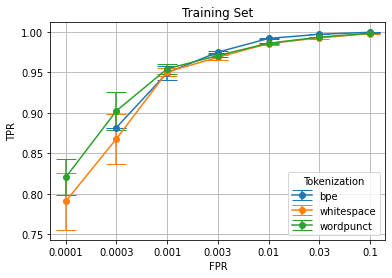

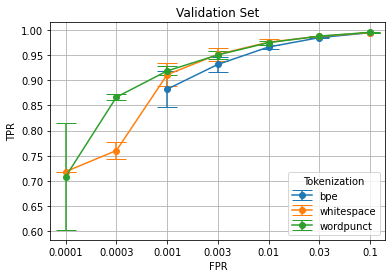

In [10]:
def training_filter(file):
    return file.endswith("training.json")
def validation_filter(file):
    return file.endswith("validation.json")
def key_extractor(file):
    return file.split("_")[0:1]

metrics_train = {}
metrics_val = {}
for folder in run_folders:
    metrics_train.update(read_cv_metrics_folder(os.path.join(INFOLDER, folder), key_extractor, training_filter))
    metrics_val.update(read_cv_metrics_folder(os.path.join(INFOLDER, folder), key_extractor, validation_filter))

TITLE = RUN_NAME.capitalize()
newkeys = [x for x in metrics_train.keys()]
ax = plot_cv_metrics_dict(metrics_train, "tpr", legendTitle=TITLE, legendValues=newkeys)
ax.set_title("Training Set")

ax = plot_cv_metrics_dict(metrics_val, "tpr", legendTitle=TITLE, legendValues=newkeys)
_ = ax.set_title("Validation Set")

In [11]:
models = defaultdict(dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for run_type in RUN_TYPES:
    nebula_vocab_file = os.path.join(INFOLDER, f"nebula_{run_type}_vocab_{VOCAB}_seqlen_{SEQ_LEN}", f"tokenizer_{VOCAB}_vocab.json")

    with open(nebula_vocab_file) as f:
        nebula_vocab = json.load(f)
    models[run_type]['class'] = TransformerEncoderChunks
    models[run_type]['config'] = {
        "vocab_size": len(nebula_vocab),
        "maxlen": SEQ_LEN,
        "chunk_size": 64,
        "dModel": 64,  # embedding & transformer dimension
        "nHeads": 8,  # number of heads in nn.MultiheadAttention
        "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
        "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        "numClasses": 1, # binary classification
        "hiddenNeurons": [64],
        "layerNorm": False,
        "dropout": 0.3,
        "mean_over_sequence": False,
        "norm_first": True
    }

In [20]:
metrics_val = defaultdict(list)
model_files = defaultdict(list)
for folder in run_folders:
    key = folder.split("_")[1]
    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_val_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = []
        print(f"[*] In process: {key}")

        folder = os.path.join(INFOLDER, folder)
        data_splits = read_cv_data_splits(folder)
        
        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]
        
        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                data_splits[i]["X_test"],
                data_splits[i]["y_test"],
                model_name=f"{key}_split_{i}",
                batch_size=96
            )
            fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true, y_pred, metrics_full=True)
            metrics.append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_val[key] = metrics

base_fpr_val, tprs_mean_val, tprs_std_val = allign_metrics(metrics_val)

[*] In process: bpe
[*] Running ROC for split: 0
Evaluating bpe_split_0 | Size: 5397313...


100%|██████████| 265/265 [00:07<00:00, 34.22it/s]


[*] Running ROC for split: 1
Evaluating bpe_split_1 | Size: 5397313...


100%|██████████| 265/265 [00:07<00:00, 34.61it/s]


[*] Running ROC for split: 2
Evaluating bpe_split_2 | Size: 5397313...


100%|██████████| 265/265 [00:08<00:00, 30.78it/s]


[*] In process: whitespace
[*] Running ROC for split: 0
Evaluating whitespace_split_0 | Size: 5397249...


100%|██████████| 265/265 [00:08<00:00, 31.07it/s]


[*] Running ROC for split: 1
Evaluating whitespace_split_1 | Size: 5397249...


100%|██████████| 265/265 [00:08<00:00, 32.17it/s]


[*] Running ROC for split: 2
Evaluating whitespace_split_2 | Size: 5397249...


100%|██████████| 265/265 [00:08<00:00, 32.34it/s]


[*] In process: wordpunct
[*] Running ROC for split: 0
Evaluating wordpunct_split_0 | Size: 5397249...


100%|██████████| 265/265 [00:07<00:00, 34.23it/s]


[*] Running ROC for split: 1
Evaluating wordpunct_split_1 | Size: 5397249...


100%|██████████| 265/265 [00:07<00:00, 33.88it/s]


[*] Running ROC for split: 2
Evaluating wordpunct_split_2 | Size: 5397249...


100%|██████████| 265/265 [00:08<00:00, 32.18it/s]


,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,AUC,F1,Recall,Precision,Accuracy
bpe,0.321862,0.521305,0.820776,0.920455,0.966978,0.984600,0.994558,0.998620,0.997335,0.984719,0.986163,0.983296,0.979311
whitespace,0.537688,0.697909,0.896513,0.947462,0.974895,0.987387,0.994947,0.998970,0.997885,0.986956,0.986317,0.987622,0.982371
wordpunct,0.577592,0.685322,0.891858,0.947856,0.975884,0.987891,0.995044,0.999086,0.997943,0.987215,0.985171,0.989275,0.982752


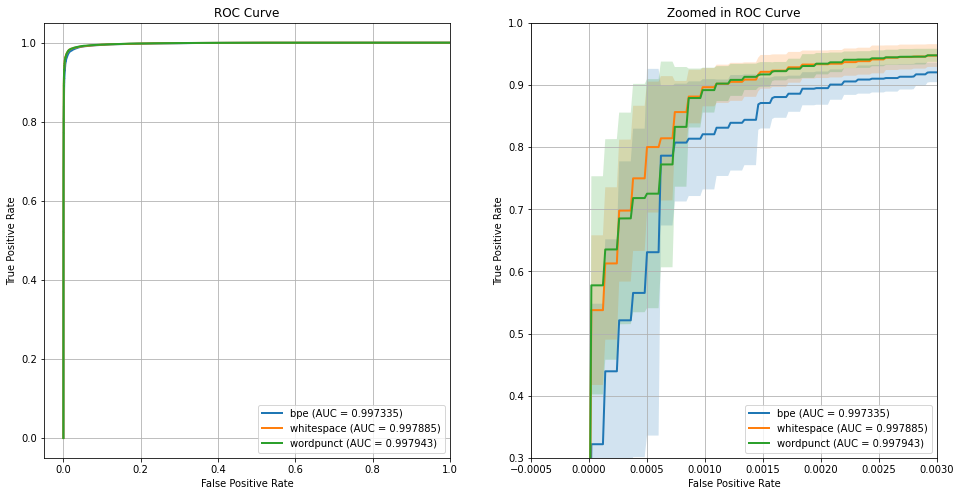

In [21]:
df, axs_val = report_alligned_metrics(
    base_fpr_val,
    tprs_mean_val,
    tprs_std_val,
    metrics_val,
    xlim=[-0.0005, 0.003],
    ylim=[0.3, 1.0],
    metrics_full=True
)
df

## Test set ROCs

In [14]:
model_files = defaultdict(list)
metrics_test = defaultdict(list)
for folder in run_folders:
    key = '_'.join(folder.split("_")[1:-3])
    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_test_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = []
        print(f"[*] In process: {key}")
        folder = os.path.join(INFOLDER, folder)

        data_folder = [x for x in os.listdir(INFOLDER) if str(key) in x and "vocab" in x][0]
        X_test = np.load(os.path.join(INFOLDER, data_folder, f"x_test_{LIMIT}.npy"))
        y_test = np.load(os.path.join(INFOLDER, data_folder, f"y_test_{LIMIT}.npy"))
        
        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]

        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                X_test,
                y_test,
                model_name=f"{key}_split_{i}",
                batch_size=64
            )
            fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true, y_pred, metrics_full=True)
            metrics.append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_test[key] = metrics


,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,AUC,F1,Recall,Precision,Accuracy
bpe,0.304016,0.381864,0.521288,0.707930,0.786026,0.856110,0.907795,0.953951,0.965742,0.913611,0.877805,0.952906,0.910381
whitespace,0.291786,0.365912,0.570281,0.706016,0.792655,0.860541,0.913042,0.953809,0.966435,0.906767,0.853735,0.967649,0.905306
wordpunct,0.282038,0.404623,0.553972,0.697472,0.809943,0.851076,0.902655,0.949094,0.962962,0.904870,0.844376,0.974915,0.904138


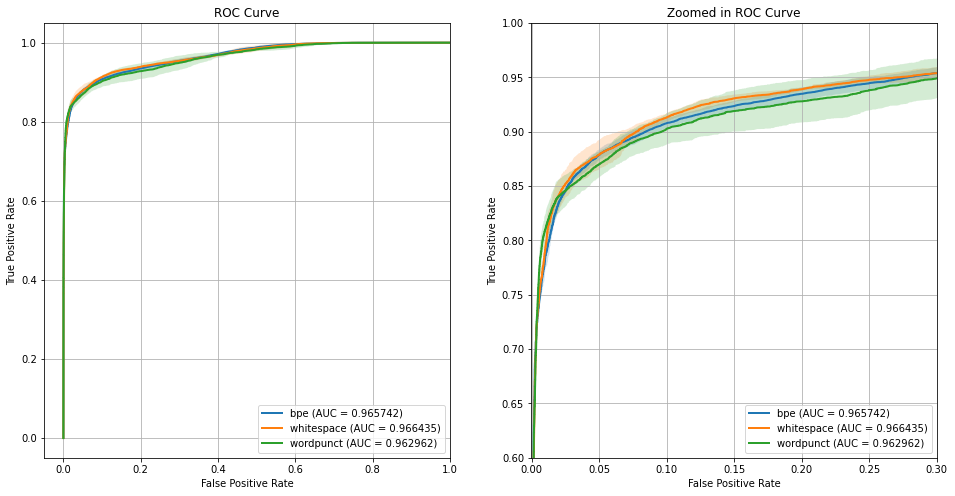

In [15]:
base_fpr_test, tprs_mean_test, tprs_std_test = allign_metrics(metrics_test)

df, axs_test = report_alligned_metrics(
    base_fpr_test,
    tprs_mean_test,
    tprs_std_test,
    metrics_test,
    metrics_full=True
)
df

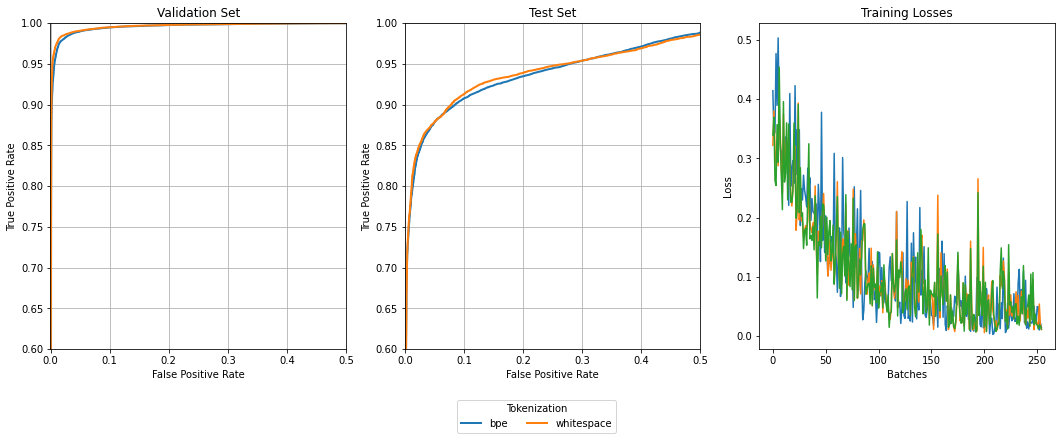

In [16]:
import matplotlib.pyplot as plt

YLIM = [0.6, 1]
XLIM = [-0.0005, 0.5]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for key in tprs_mean_val:
    if key == 0.01:
        continue
    plot_roc_curve(base_fpr_val, tprs_mean_val[key], model_name=key, ax=axs[0], ylim=YLIM, xlim=XLIM)
    plot_roc_curve(base_fpr_test, tprs_mean_test[key], model_name=key, ax=axs[1], ylim=YLIM, xlim=XLIM)

axs[0].set_title("Validation Set")
axs[1].set_title("Test Set")
#[ax.legend(loc="lower right", title="Learning rate") for ax in axs[0:2]]
[ax.set_ylabel("True Positive Rate") for ax in axs[0:2]]
[ax.set_xlabel("False Positive Rate") for ax in axs[0:2]]
[ax.grid() for ax in axs[0:2]]

start = 100
n = 10
for folder in run_folders:
    key = folder.split("_")[1]
    train_folder = os.path.join(INFOLDER, folder, "training_files")
    train_losses = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if "trainLosses" in x][0]
    loss_mean = np.load(train_losses)[start::n]    
    axs[2].plot(loss_mean, label=key)
axs[2].set_xlabel("Batches")
axs[2].set_ylabel("Loss")
axs[2].set_title("Training Losses")

# make one common legend below the plots so it does not overlap with the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, title=RUN_NAME.capitalize(), bbox_to_anchor=(0.5, -0.08))

_ = fig.savefig(os.path.join(REPO_ROOT, "img", f"results_{'_'.join(RUN_NAME.split(' '))}.png"), dpi=300, bbox_inches='tight')